#Evaluación de Conocimientos (EC)
##Escuela de Posgrado - Universidad Nacional del Altiplano de Puno
###Doctorado en Ciencias de la Computación
####Curso: Minería de Datos - 2025-I
#####Prof. Dr. Ivar Vargas Belizario
######Alumno: Israel N. Chaparro-Cruz
[Link del Notebook](https://colab.research.google.com/drive/1z2-hWYgzJqJjYHqiK_sVHzA0DdE-esyc?usp=sharing)

# 1. Descripción del problema

Se ha seleccionado el problema: [Melanoma](https://www.kaggle.com/datasets/ivarvb/melanomads). Además, se ha seleccionado como estructura de datos un [Vision Transformers](https://docs.pytorch.org/vision/main/models/vision_transformer.html). La implementación se realiza utilizando **PyTorch**.

## Clasificación de Melanoma con Vision Transformers usando Data Augmentation, Transfer Learning y Fine-Tuning.

El melanoma es uno de los tipos más agresivos de cáncer de piel y su detección temprana resulta crucial para mejorar el pronóstico de los pacientes. A pesar de los avances en la dermatología clínica, el diagnóstico visual basado en imágenes dermatoscópicas sigue siendo un desafío, incluso para expertos, debido a la gran variabilidad en la apariencia de las lesiones cutáneas.

#2. Descripción del atributo objetivo


En este proyecto, abordamos el problema de **clasificación automática de imágenes dermatoscópicas** para distinguir entre dos clases:

- **Benign (Benigna):** Lesiones no cancerígenas.
- **Malignant (Maligna):** Lesiones correspondientes a melanoma.

El número de imágenes por clase para cada conjunto es:

| Conjunto     | Cantidad de Imágenes | Clases      | Distribución de Clases        | Tipo de Etiqueta |
|--------------|----------------------|-------------|-------------------------------|------------------|
| Entrenamiento | 4000                 | Benign, Malignant | 2000 benign / 2000 malignant | Supervisada      |
| Prueba        | 400                  | Benign, Malignant | 200 benign / 200 malignant   | Supervisada      |

Dado que las clases están balanceadas y las imágenes presentan variaciones de textura, color y forma, se plantea este problema como una tarea de **clasificación binaria supervisada**.

#3. Principales Desafíos

Los principales desafíos presentados son:

1.   **Transfer Learning con Vision Transformers**: A diferencia de las redes neuronales convolucionales, el Vision Transformer no está dividido en Feature Extraction y Classification. Para el Vision Transformers, fue necesario reemplazar la cabeza de este por una capa lineal sin función de activación que mapee el Transformer Encoder a una sola neurona (clasiicación binaria).
2.   **Fine-Tuning vs Learning Rate**: Se aplicó Fine-Tuning sobre el modelo al cual se le aplicó Transfer Learning, esto requirió ajustar el valor de Learning Rate para no provocar cambios bruscos en los pesos del modelo base. Pese a los ajustes, no se obtuvieron mejores resultados respecto a Transfer Learning.
3.   **Overfitting vs Data Augmentation**: El data augmentation es un tipo especial de regularización que evita overfitting, esto requirió ajustar la cantidad de Data Augmentation para salir del Overfitting y evitar caer en Underfitting.
4.   **Threshold**: Se calculó la curva AUC y el threshold óptimo, mejorandose levemente la performance del modelo.

#4. Descripción de la solución

Para ello, emplearemos una arquitectura de tipo **Vision Transformer (ViT)**, específicamente `ViT_B_16`, preentrenada en ImageNet, aplicando técnicas de **data augmentation, transfer learning y fine-tuning** para ajustar sus capacidades a esta tarea médica especializada.

Este enfoque no solo busca lograr una alta precisión, sino también aportar una herramienta potencialmente útil como apoyo diagnóstico automatizado en entornos clínicos.

El primer paso será descomprimir el conjunto de datos [Melanoma](https://www.kaggle.com/datasets/ivarvb/melanomads).

In [ ]:
!unzip -q 'melanoma.zip' -d melanoma

###4.1 Importamos las librerías necesarias

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 4.2 Cargaremos un Vision Transformers pre-entrenado en ImageNet

Un Vision Transformer (ViT) es una arquitectura de red neuronal que aplica el modelo Transformer, originalmente diseñado para procesamiento de texto, al reconocimiento de imágenes.
En este caso, usaremos un ViT pre-entrenado en ImageNet.

In [ ]:
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
vit_model = vit_b_16(weights=weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 185MB/s]


## 4.3 Congelar el Modelo (Freeze)

Congelamos los parámetros para aprovechar el modelo pre-entrenado y acelerar el entrenamiento.

In [ ]:
for param in vit_model.parameters():
    param.requires_grad = False

##4.4 Añadir la Capa de Clasificación

Un modelo entrenado en ImageNet clasifica entre 1000 diferentes clases, por lo tanto tiene 1000 neuronas de salida. Para nuestro problema, solo es necesaria una neurona de salida (**clasificación binaria**). Lo que haremos es reemplazar la cabeza de nuestro ViT por una capa que mapee la salida a solo 1 neurona.

In [ ]:
vit_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
vit_model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=1),
)

##4.5 Compilar el Modelo

Estableceremos como función de costo/error/pérdida el Binary Cross Entropy Loss y como optmizador Adam.

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(vit_model.parameters())
my_model = torch.compile(vit_model.to(device))

##4.6 Aumento de Datos

Primero, utilizaremos el pre-procesamiento de la entrada que se encuentra en los pesos importados.

In [ ]:
pre_trans = weights.transforms()

Para mejorar el conjunto de datos, realizaremos un aumento de datos aleatorio.

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (224, 224)

random_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25)
    #transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.8, 1), ratio=(1, 1)),
    #transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2)
])

##4.7 Cargando el Conjunto de Datos

Realizaremos herencia de la clase Dataset de PyTorch para poder cargar las imágenes (.jpg) y sus etiquetas.

In [ ]:
DATA_LABELS = ["benign", "malignant"]

class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []

        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_trans(img).to(device))
                self.labels.append(torch.tensor(l_idx).to(device).float())


    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

Seleccionaremos un batch_size (n) e instanciaremos los objetos necesarios para leer el conjunto de datos.

In [ ]:
n = 32

train_path = "/content/melanoma/train/"
train_data = MyDataset(train_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_path = "/content/melanoma/test/"
valid_data = MyDataset(valid_path)
valid_loader = DataLoader(valid_data, batch_size=n, shuffle=False)
valid_N = len(valid_loader.dataset)

##4.8 Entrenar el Modelo

Usaremos algunas unciones personalizadas para calcular el accuracy (exactitud), entrenar el modelo y validarlo.

In [ ]:
def get_batch_accuracy(output, y, N):
    zero_tensor = torch.tensor([0]).to(device)
    pred = torch.gt(output, zero_tensor)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N


def train(model, check_grad=False):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = torch.squeeze(model(random_trans(x)))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    if check_grad:
        print('Last Gradient:')
        for param in model.parameters():
            print(param.grad)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

def validate(model):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = torch.squeeze(model(x))

            loss += loss_function(output, y.float()).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [ ]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, check_grad=False)
    validate(my_model)

Epoch: 0


W0531 04:51:00.168000 720 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Train - Loss: 42.7654 Accuracy: 0.8580
Valid - Loss: 3.6659 Accuracy: 0.8750
Epoch: 1
Train - Loss: 29.3651 Accuracy: 0.9077
Valid - Loss: 3.3812 Accuracy: 0.8850
Epoch: 2
Train - Loss: 26.9977 Accuracy: 0.9177
Valid - Loss: 3.2289 Accuracy: 0.8975
Epoch: 3
Train - Loss: 25.2080 Accuracy: 0.9210
Valid - Loss: 3.2005 Accuracy: 0.8950
Epoch: 4
Train - Loss: 24.0949 Accuracy: 0.9255
Valid - Loss: 3.1126 Accuracy: 0.8975
Epoch: 5
Train - Loss: 23.1394 Accuracy: 0.9285
Valid - Loss: 3.0046 Accuracy: 0.9025
Epoch: 6
Train - Loss: 21.9208 Accuracy: 0.9357
Valid - Loss: 3.0765 Accuracy: 0.9025
Epoch: 7
Train - Loss: 21.9886 Accuracy: 0.9300
Valid - Loss: 3.0288 Accuracy: 0.9100
Epoch: 8
Train - Loss: 21.0638 Accuracy: 0.9360
Valid - Loss: 2.9689 Accuracy: 0.9075
Epoch: 9
Train - Loss: 21.1163 Accuracy: 0.9385
Valid - Loss: 2.9319 Accuracy: 0.9100


##4.9 Descongelar el modelo para aplicar Fine-Tuning

Descongelaremos el modelo por completo y aplicaremos un learning rate bajo a fin de permitir al modelo adecuarse mejor al dataset.

In [ ]:
for param in my_model.parameters():
    param.requires_grad = True

In [ ]:
optimizer = Adam(my_model.parameters(), lr=1e-5)

In [ ]:
epochs = 1

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model)
    validate(my_model)

Epoch: 0
Train - Loss: 20.5465 Accuracy: 0.9352
Valid - Loss: 2.9480 Accuracy: 0.9075


##4.10 Métricas y Cálculo del Threshold Óptimo

Para el conjunto de test, calcularemos las etiquetas tomando en cuenta un Threshold de 0.5.

In [ ]:
my_model.eval()
my_model.to(device)
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = my_model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

En base a los resultados obtenidos, calcularemos la matriz de conusión y las métricas.

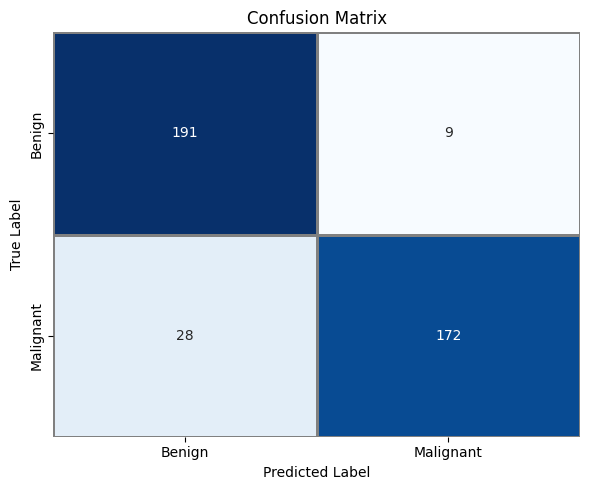

Reporte de métricas:
               precision    recall  f1-score   support

      Benign       0.87      0.95      0.91       200
   Malignant       0.95      0.86      0.90       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

labels = ["Benign", "Malignant"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar=False, linewidths=1, linecolor='gray')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, target_names=["Benign", "Malignant"])
print("Reporte de métricas:\n", report)

Tenemos un total de 37 muestras mal clasificaads de 400 en total. Podemos mejorar un poco la performance del modelo eligiendo un mejor Threshold. Para esto calcularemos la curva AUC y el Threshold óptimo.

AUC: 0.9655250000000001


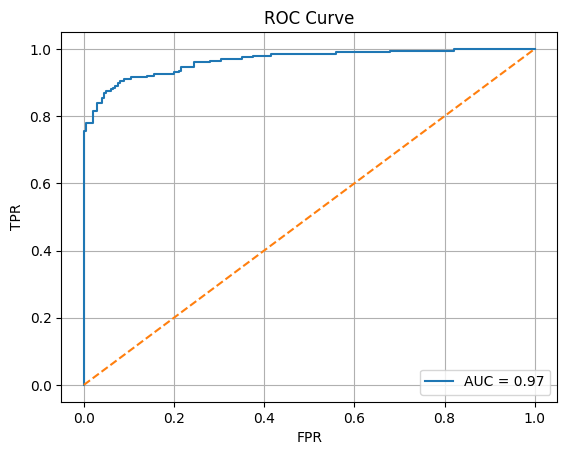

In [ ]:
y_prob = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = my_model(images)
        probs = torch.sigmoid(outputs)
        y_prob.extend(probs.cpu().numpy())

auc_score = roc_auc_score(y_true, y_prob)
print("AUC:", auc_score)

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
youden_j = tpr - fpr

optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Threshold óptimo (Youden's J): {optimal_threshold:.4f}")

Threshold óptimo (Youden's J): 0.3572


Ahora, podemos recalcular la matriz de confusión y las métrica usando el Threshold óptimo.

In [ ]:
my_model.eval()
my_model.to(device)
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = my_model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > optimal_threshold).int()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

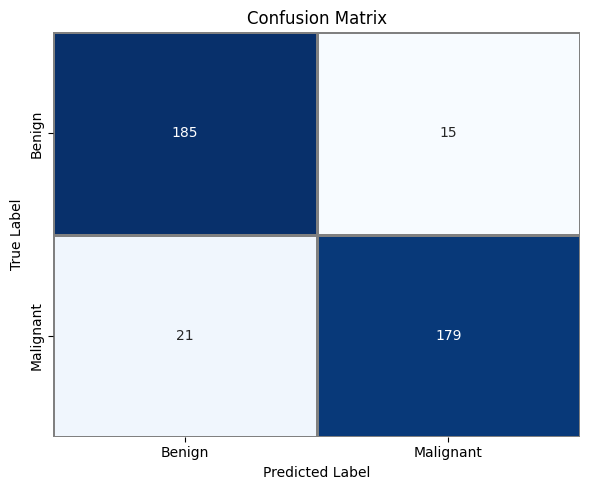

Reporte de métricas:
               precision    recall  f1-score   support

      Benign       0.90      0.93      0.91       200
   Malignant       0.92      0.90      0.91       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

labels = ["Benign", "Malignant"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar=False, linewidths=1, linecolor='gray')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, target_names=["Benign", "Malignant"])
print("Reporte de métricas:\n", report)

Con este threshold hemos mal-clasificado solo 36 imágenes,  ganando una respecto al threshold anterior. Además, algunas métricas han variado pero el rendimiento ha mejorado ligeramente.
Además, un threshold más bajo para esta clase de casos es mejor (se prefiere falsos positivos sobre falsos negativos).

Gracias.